In [269]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

In [270]:
# Loading the data, it comes from a lot of joined datasets
df = pd.read_csv("train_data.csv", index_col=0).reset_index(drop=True)
df.head()

# Drop information that cannot be substituted
def dropnas(df):
    df = df.loc[~df["FTHG"].isna() & ~df["FTAG"].isna()].copy()
    df = df.loc[~df["HTHG"].isna() & ~df["HTAG"].isna()].copy()
    df = df.loc[~df["HomeTeam"].isna() & ~df["AwayTeam"].isna()].copy()
    df = df.loc[~df["Div"].isna() & ~df["Date"].isna()].copy()
    return df

print("Nrows before dropping:", df.shape[0])
df = dropnas(df)
print("Nrows after dropping:", df.shape[0])

# Realistically, we can expect there to be less than 5 goals from each side in a match, but well cap it off at 10 for good measure
print("Nrows before dropping:", df.shape[0])
df = df.loc[~df["FTAG"].isna() & ~df["HTAG"].isna() & ~df["FTHG"].isna() & ~df["HTHG"].isna()].copy()
df = df.loc[(df["FTAG"] >= 0) & (df["FTAG"]<= 5) & (df["FTAG"] >= 0) & (df["FTHG"] <= 5)].copy()
print("Nrows after dropping:", df.shape[0])

# Let's see if we can fill in odds values
bet_columns = ["B365", "BS", "BW", "GB", "IW", "LB", "PS", "SO", "SB", "SJ", "SY", "VC", "WH"]
home_bet = [col+"H" for col in bet_columns]
draw_bet = [col+"D" for col in bet_columns]
away_bet = [col+"A" for col in bet_columns]

df["AvgH"] = df[home_bet].mean(axis=1)
df["AvgD"] = df[draw_bet].mean(axis=1)
df["AvgA"] = df[away_bet].mean(axis=1)

df["InvH"] = 1 / df["AvgH"]
df["InvD"] = 1 / df["AvgD"]
df["InvA"] = 1 / df["AvgA"]

df["OddsInv"] = df["InvH"] + df["InvD"] + df["InvA"]

# The good news is, that none of the odds sum are bellow 1, as that would mean a loss for the broker
# We can see that some brokers collect a higher premium for the bets, reaching almost 20% in some cases
print("Nrows before dropping:", df.shape[0])
df = df.loc[(df["OddsInv"]>1) & ~df["AvgH"].isna() & ~df["AvgD"].isna() & ~df["AvgA"].isna()]
print("Nrows after dropping:", df.shape[0])

# Now let's fill in the missing half-time and full-time results
def calculate_win(home_goals, away_goals):
    results = []
    for home, away in zip(home_goals, away_goals):
        if home < away:
            results.append("A")
        elif home > away:
            results.append("H")
        else:
            results.append("D")
    return results

df["HTR"] = calculate_win(df["HTHG"], df["HTAG"])
df["HTR"] = df["HTR"].map({"H": 1, "D": 0, "A": -1})
df["FTR"] = calculate_win(df["FTHG"], df["FTAG"])
df["FTR"] = df["FTR"].map({"H": 1, "D": 0, "A": -1})

print("Nrows before dropping:", df.shape[0])
df = df.loc[~df["HTR"].isna() & ~df["FTR"].isna()]
print("Nrows after dropping:", df.shape[0])

# Parse dates for later sampling
df["Date"] = df["Date"].apply(
        lambda date: datetime.strptime(date, "%d/%m/%y") if len(date)==8 else datetime.strptime(date, "%d/%m/%Y")
    )

df["Year"] = df["Date"].apply(lambda x: x.year)

df = df.loc[df["season"].isin([1920, 2021, 2122])].sort_values(by="Date", ascending=True).copy()
print("Final nrows:", df.shape[0])

C:\Users\vojte\AppData\Local\Temp\ipykernel_16484\2480145336.py:2: DtypeWarning: Columns (65,76,91,154,170,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train_data.csv", index_col=0).reset_index(drop=True)


Nrows before dropping: 155173
Nrows after dropping: 153086
Nrows before dropping: 153086
Nrows after dropping: 151390
Nrows before dropping: 151390
Nrows after dropping: 151037
Nrows before dropping: 151037
Nrows after dropping: 151037
Final nrows: 20207


In [274]:
chosen_columns = ["Div", "Date", "season", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HY", "AY", "HR", "AR", "HS", "AS", "HST", "AST", "AvgH", "AvgD", "AvgA"]
df = df[chosen_columns].dropna().reset_index(drop=True).copy()
indexes = list(df.index)

In [4]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
clf.fit(df[chosen_columns[5:]])
pred = clf.predict(df[chosen_columns[5:]])

outlier_df = df[chosen_columns[5:]].iloc[indexes].copy()
outlier_df["status"] = pred

from sklearn.model_selection import train_test_split
outlier_df["status"] = outlier_df["status"].apply(lambda x: int(x==-1))
y_list = outlier_df.pop("status")
X_train, X_test, y_train, y_test = train_test_split(outlier_df, y_list, test_size=0.2, stratify=y_list, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

outlier_df[["prob_NOUTL", "prob_OUTL"]] = clf.predict_proba(outlier_df)
outlier_df["status"] = y_list

full_df = df.copy()
full_df[["prob_NOUTL", "prob_OUTL"]] = clf.predict_proba(full_df[chosen_columns[5:]])
full_df["outlier_prob"] = full_df["prob_OUTL"]
full_df.pop("prob_NOUTL")
full_df.pop("prob_OUTL")

df = full_df.copy()
print("outliers labelled!")

outliers labelled!


In [5]:
df["HST_ratio"] = df["HST"] / (df["HS"] + df["HST"])
df["AST_ratio"] = df["AST"] / (df["AS"] + df["AST"])

In [6]:
master_df = pd.DataFrame()
total_cumulative_stats = {}
for season in [1920, 2021]:
    cumulative_stats = {}
    home_values_for_tdf = {}
    away_values_for_tdf = {}
    tdf = df.loc[(df["Div"] == "E0") & (df["season"]==season)].sort_values(by="Date", ascending=True).copy()
    for i in list(tdf.index):

        # Model home performance
        home = tdf.at[i, "HomeTeam"]
        ftr = tdf.at[i, "FTR"]
        if ftr==1:
            homepoints = 3
            awaypoints = 0
        elif ftr==-1:
            homepoints = 0
            awaypoints = 3
        else:
            homepoints = 1
            awaypoints = 1
        s1 = "H"
        cumulative_stats[home] = cumulative_stats.get(home, {})
        for col in ["FT0G", "0Y", "0R", "0S", "0ST"]:
            colname = col.replace("0", s1)
            cumulative_stats[home][colname] = cumulative_stats[home].get(colname, 0)
            home_values_for_tdf[colname+"_bm"] = home_values_for_tdf.get(colname+"_bm", []) + [cumulative_stats[home].get(colname, 0)]
            value = tdf.at[i, colname]
            cumulative_stats[home][colname] = cumulative_stats[home].get(colname, 0) + value
        
        cumulative_stats[home]["HST_ratio"] = cumulative_stats[home].get("HST_ratio", [0])
        home_values_for_tdf["HST_ratio"+"_bm"] = home_values_for_tdf.get("HST_ratio"+"_bm", []) + [np.array([cumulative_stats[home].get("HST_ratio", [0])]).mean()]
        hst_value = tdf.loc[i, "HST_ratio"]
        cumulative_stats[home]["HST_ratio"] = cumulative_stats[home].get("HST_ratio", [0]) + [hst_value]

        cumulative_stats[home]["HP"] = cumulative_stats[home].get("HP", 0)
        home_values_for_tdf["HP"+"_bm"] = home_values_for_tdf.get("HP"+"_bm", []) + [cumulative_stats[home].get("HP", 0)]
        cumulative_stats[home]["HP"] = cumulative_stats[home].get("HP", 0) + homepoints
        home_values_for_tdf["HP"+"_am"] = home_values_for_tdf.get("HP"+"_am", []) + [cumulative_stats[home].get("HP", 0)]
        
        # Model for away performance
        away = tdf.at[i, "AwayTeam"]
        s1 = "A"
        cumulative_stats[away] = cumulative_stats.get(away, {})
        for col in ["FT0G", "0Y", "0R", "0S", "0ST"]:
            colname = col.replace("0", s1)
            cumulative_stats[away][colname] = cumulative_stats[away].get(colname, 0)
            away_values_for_tdf[colname+"_bm"] = away_values_for_tdf.get(colname+"_bm", []) + [cumulative_stats[away].get(colname, 0)]
            value = tdf.at[i, colname]
            cumulative_stats[away][colname] = cumulative_stats[away].get(colname, 0) + value
        
        cumulative_stats[away]["AST_ratio"] = cumulative_stats[away].get("AST_ratio", [0])
        away_values_for_tdf["AST_ratio"+"_bm"] = away_values_for_tdf.get("AST_ratio"+"_bm", []) + [np.array([cumulative_stats[away].get("AST_ratio", [0])]).mean()]
        ast_value = tdf.loc[i, "AST_ratio"]
        cumulative_stats[away]["AST_ratio"] = cumulative_stats[away].get("AST_ratio", [0]) + [ast_value]

        cumulative_stats[away]["AP"] = cumulative_stats[away].get("AP", 0)
        away_values_for_tdf["AP"+"_bm"] = away_values_for_tdf.get("AP"+"_bm", []) + [cumulative_stats[away].get("AP", 0)]
        cumulative_stats[away]["AP"] = cumulative_stats[away].get("AP", 0) + awaypoints
        away_values_for_tdf["AP"+"_am"] = away_values_for_tdf.get("AP"+"_am", []) + [cumulative_stats[away].get("AP", 0)]



    for col in home_values_for_tdf.keys():
        tdf[col] = home_values_for_tdf[col]

    for col in away_values_for_tdf.keys():
        tdf[col] = away_values_for_tdf[col]

    if master_df.shape[0]==0:
        master_df = tdf.copy()
    else:
        master_df = pd.concat([master_df, tdf])

    total_cumulative_stats[season] = cumulative_stats

In [7]:
flattened_data = []
for season, teams in total_cumulative_stats.items():
    for team, stats in teams.items():
        row = {'season': season, 'team': team}
        row.update(stats)
        flattened_data.append(row)

league_df = pd.DataFrame(flattened_data).copy()
league_df["HST_ratio"] = league_df["HST_ratio"].apply(lambda x: np.mean(np.array(x)))
league_df["AST_ratio"] = league_df["AST_ratio"].apply(lambda x: np.mean(np.array(x)))

In [30]:
train_df = df.loc[(df["Div"] == "E0") & ((df["season"]==1920) | (df["season"]==2021))].sort_values(by="Date", ascending=True).copy()
train_df = train_df[["season", "Date", "HomeTeam", "AwayTeam", "FTR"]].copy()

for col in list(league_df.columns[2:]):
    mapper = league_df.groupby(["team", "season"])[col].mean().to_dict()
    homevals = []
    awayvals = []
    for i in list(train_df.index):
        homevals.append(mapper.get((train_df.at[i, "HomeTeam"], train_df.at[i, "season"]), None))
        awayvals.append(mapper.get((train_df.at[i, "AwayTeam"], train_df.at[i, "season"]), None))
    train_df[col+"_H"] = homevals
    train_df[col+"_A"] = awayvals

In [29]:
test_df = df.loc[(df["Div"] == "E0") & (df["season"]==2122)].sort_values(by="Date", ascending=True).copy()
test_df = test_df[["season", "Date", "HomeTeam", "AwayTeam", "FTR"]].copy()

for col in list(league_df.columns[2:]):
    mapper = league_df.groupby("team")[col].mean().to_dict()
    test_df[col+"_H"] = test_df["HomeTeam"].apply(lambda x: mapper.get(x, None))
    test_df[col+"_A"] = test_df["AwayTeam"].apply(lambda x: mapper.get(x, None))

In [44]:
for col in test_df.columns:
    if test_df[col].isna().sum()>0:
        test_df[col] = test_df[col].apply(lambda x: x if (x and not pd.isna(x)) else test_df[col].mean())

<Axes: xlabel='HP_H_bin', ylabel='HP_A_bin'>

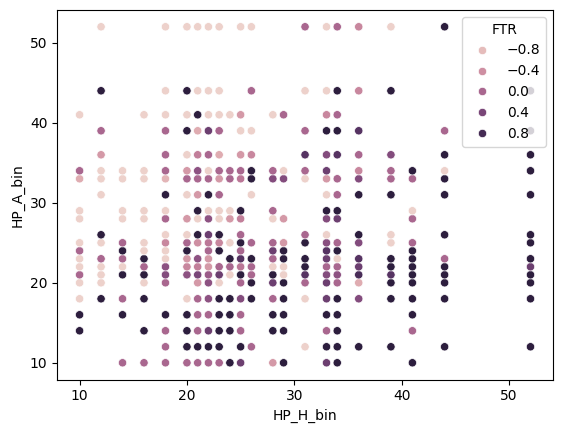

In [59]:
# 1. Bin the data
bin_size = 1  # Change this to your preferred bin size
train_df["HomeResult"] = train_df["FTHG_H"] - train_df["FTAG_A"]
train_df['HP_H_bin'] = np.floor(train_df['HP_H'] / bin_size) * bin_size
train_df['HP_A_bin'] = np.floor(train_df['HP_A'] / bin_size) * bin_size

# 2. Calculate the average results for each bin
binned_avg = train_df.groupby(['HP_H_bin', 'HP_A_bin'])['FTR'].mean().reset_index()

sns.scatterplot(
    data=binned_avg,
    x="HP_H_bin",
    y="HP_A_bin",
    hue="FTR"
)

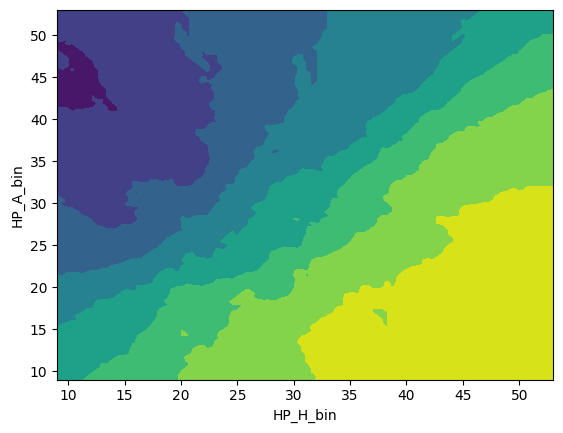

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = binned_avg[["HP_H_bin", "HP_A_bin", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=100)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

<Axes: xlabel='HST_ratio_H_bin', ylabel='AST_ratio_A_bin'>

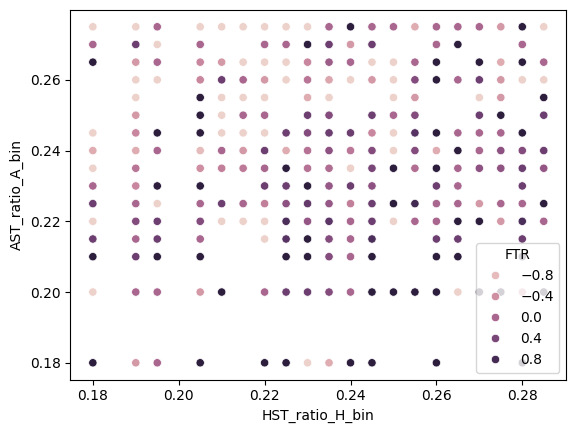

In [81]:
# 1. Bin the data
bin_size = 0.005  # Change this to your preferred bin size
train_df['HST_ratio_H_bin'] = np.floor(train_df['HST_ratio_H'] / bin_size) * bin_size
train_df['AST_ratio_A_bin'] = np.floor(train_df['AST_ratio_A'] / bin_size) * bin_size

# 2. Calculate the average results for each bin
binned_avg = train_df.groupby(['HST_ratio_H_bin', 'AST_ratio_A_bin'])['FTR'].mean().reset_index()

sns.scatterplot(
    data=binned_avg,
    x="HST_ratio_H_bin",
    y="AST_ratio_A_bin",
    hue="FTR"
)

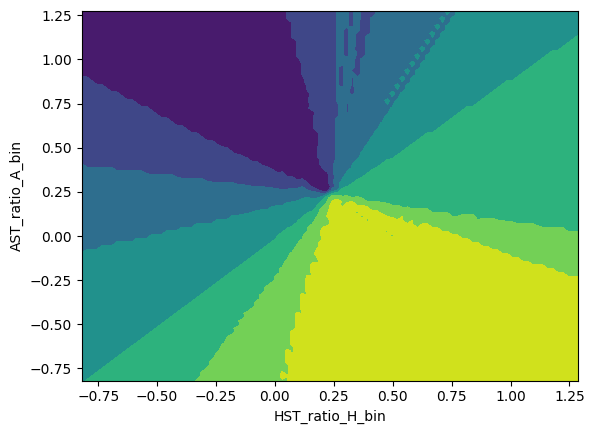

In [88]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = binned_avg[["HST_ratio_H_bin", "AST_ratio_A_bin", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=40)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

<Axes: xlabel='HY_H', ylabel='HY_A'>

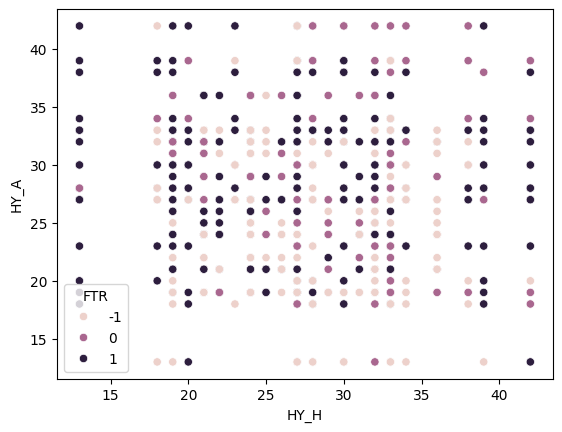

In [94]:
sns.scatterplot(
    data=train_df,
    x="HY_H",
    y="HY_A",
    hue="FTR"
)

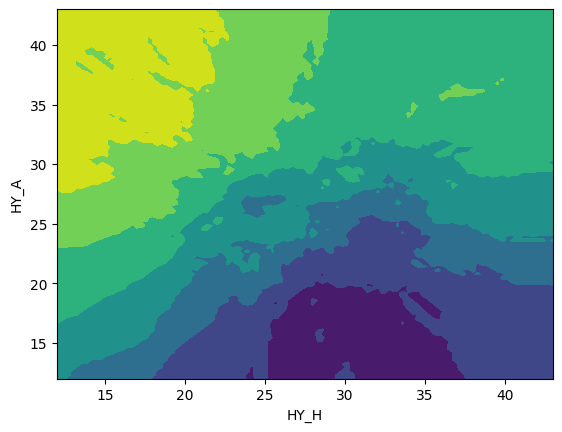

In [110]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = train_df[["HY_H", "HY_A", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=200)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

<Axes: xlabel='HS_H_bin', ylabel='HS_A_bin'>

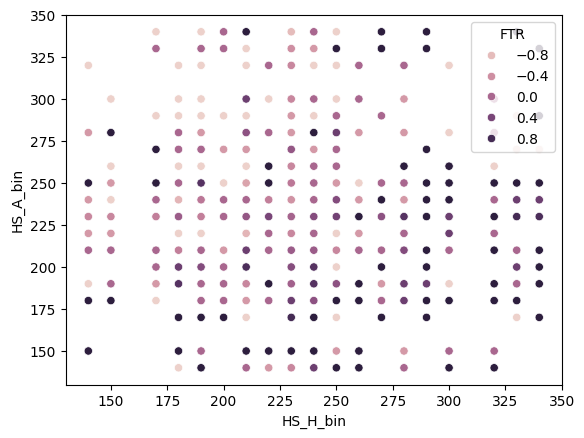

In [118]:
# 1. Bin the data
bin_size = 10  # Change this to your preferred bin size
train_df['HS_H_bin'] = np.floor(train_df['HS_H'] / bin_size) * bin_size
train_df['HS_A_bin'] = np.floor(train_df['HS_A'] / bin_size) * bin_size

# 2. Calculate the average results for each bin
binned_avg = train_df.groupby(['HS_H_bin', 'HS_A_bin'])['FTR'].mean().reset_index()

sns.scatterplot(
    data=binned_avg,
    x="HS_H_bin",
    y="HS_A_bin",
    hue="FTR"
)

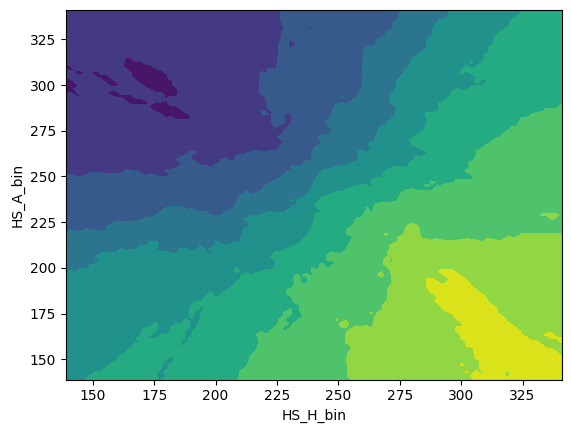

In [122]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = binned_avg[["HS_H_bin", "HS_A_bin", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=100)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

<Axes: xlabel='HomeResult_bin', ylabel='HP_H_bin'>

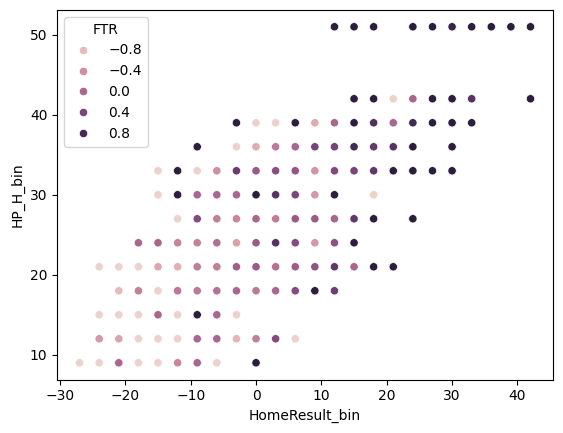

In [127]:
# 1. Bin the data
bin_size = 3  # Change this to your preferred bin size
train_df['HomeResult_bin'] = np.floor(train_df['HomeResult'] / bin_size) * bin_size
train_df['HP_H_bin'] = np.floor(train_df['HP_H'] / bin_size) * bin_size

# 2. Calculate the average results for each bin
binned_avg = train_df.groupby(['HomeResult_bin', 'HP_H_bin'])['FTR'].mean().reset_index()

sns.scatterplot(
    data=binned_avg,
    x="HomeResult_bin",
    y="HP_H_bin",
    hue="FTR"
)

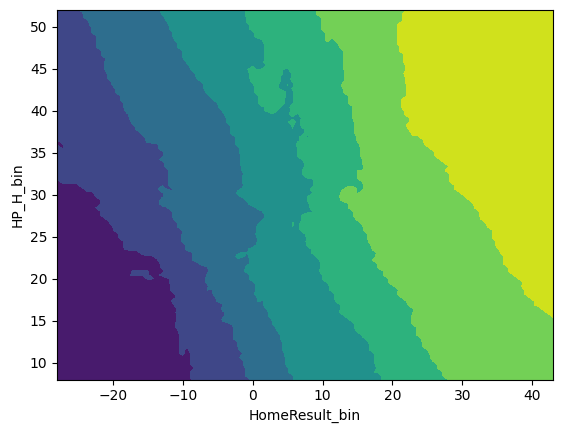

In [132]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = binned_avg[["HomeResult_bin", "HP_H_bin", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=50)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

<Axes: xlabel='HST_H_bin', ylabel='HST_A_bin'>

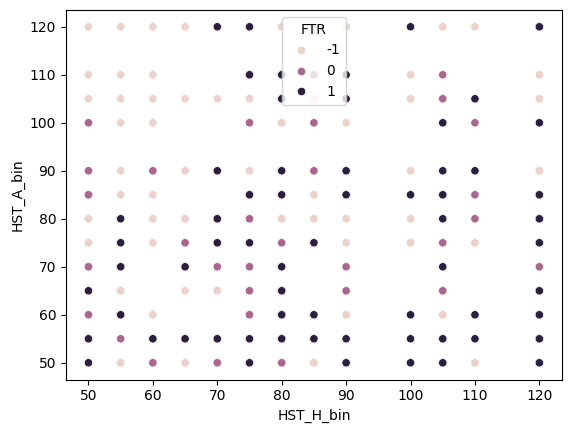

In [141]:
# 1. Bin the data
bin_size = 5  # Change this to your preferred bin size
train_df['HST_H_bin'] = np.floor(train_df['HST_H'] / bin_size) * bin_size
train_df['HST_A_bin'] = np.floor(train_df['HST_A'] / bin_size) * bin_size

# 2. Calculate the average results for each bin
binned_avg = train_df.groupby(['HST_H_bin', 'HST_A_bin'])['FTR'].mean().reset_index()

sns.scatterplot(
    data=train_df,
    x="HST_H_bin",
    y="HST_A_bin",
    hue="FTR"
)

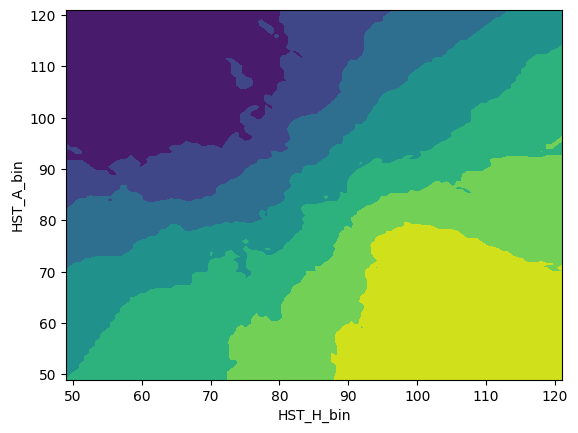

In [145]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay

X = binned_avg[["HST_H_bin", "HST_A_bin", "FTR"]].copy()
y = X.pop("FTR")

clf = KNeighborsRegressor(n_neighbors=70)
clf.fit(X, y)


DecisionBoundaryDisplay.from_estimator(clf, X)

In [179]:
# Model 1
m1feat = ["HP_H_bin", "HP_A_bin"]
binned_avg = train_df.groupby(['HP_H_bin', 'HP_A_bin'])['FTR'].mean().reset_index()
binned_avg = binned_avg.rename({val: val.replace("_bin", "") for val in m1feat}, axis=1)
X = binned_avg[["HP_H", "HP_A", "FTR"]].copy()
y = X.pop("FTR")

model1 = KNeighborsRegressor(n_neighbors=100)
model1.fit(X, y)

KNeighborsRegressor(n_neighbors=100)

In [155]:
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Model 1
m1feat = ["HP_H_bin", "HP_A_bin"]
binned_avg = train_df.groupby(['HP_H_bin', 'HP_A_bin'])['FTR'].mean().reset_index()
binned_avg = binned_avg.rename({val: val.replace("_bin", "") for val in m1feat}, axis=1)
X = binned_avg[["HP_H_bin", "HP_A_bin", "FTR"]].copy()
y = X.pop("FTR")

model1 = KNeighborsRegressor(n_neighbors=100)
model1.fit(X, y)

# Model 2
binned_avg = train_df.groupby(['HST_ratio_H_bin', 'AST_ratio_A_bin'])['FTR'].mean().reset_index()
X = binned_avg[["HST_ratio_H_bin", "AST_ratio_A_bin", "FTR"]].copy()
y = X.pop("FTR")

model2 = KNeighborsRegressor(n_neighbors=40)
model2.fit(X, y)

# Model 3
X = train_df[["HY_H", "HY_A", "FTR"]].copy()
y = X.pop("FTR")

model3 = KNeighborsRegressor(n_neighbors=200)
model3.fit(X, y)

# Model 4
binned_avg = train_df.groupby(['HS_H_bin', 'HS_A_bin'])['FTR'].mean().reset_index()
X = binned_avg[["HS_H_bin", "HS_A_bin", "FTR"]].copy()
y = X.pop("FTR")

model4 = KNeighborsRegressor(n_neighbors=100)
model4.fit(X, y)

# Model 5
binned_avg = train_df.groupby(['HomeResult_bin', 'HP_H_bin'])['FTR'].mean().reset_index()
X = binned_avg[["HomeResult_bin", "HP_H_bin", "FTR"]].copy()
y = X.pop("FTR")

model5 = KNeighborsRegressor(n_neighbors=50)
model5.fit(X, y)

# Model 6
binned_avg = train_df.groupby(['HST_H_bin', 'HST_A_bin'])['FTR'].mean().reset_index()
X = binned_avg[["HST_H_bin", "HST_A_bin", "FTR"]].copy()
y = X.pop("FTR")

model6 = KNeighborsRegressor(n_neighbors=70)
model6.fit(X, y)

KNeighborsRegressor(n_neighbors=70)

In [281]:
train_df = df.loc[(df["Div"] == "E0") & ((df["season"]==1920) | (df["season"]==2021))].sort_values(by="Date", ascending=True).copy()
train_df = train_df[["season", "Date", "HomeTeam", "AwayTeam", "FTR", "AvgH", "AvgD", "AvgA"]].copy()

for col in list(league_df.columns[2:]):
    mapper = league_df.groupby(["team", "season"])[col].mean().to_dict()
    homevals = []
    awayvals = []
    for i in list(train_df.index):
        homevals.append(mapper.get((train_df.at[i, "HomeTeam"], train_df.at[i, "season"]), None))
        awayvals.append(mapper.get((train_df.at[i, "AwayTeam"], train_df.at[i, "season"]), None))
    train_df[col+"_H"] = homevals
    train_df[col+"_A"] = awayvals

In [285]:
test_df = df.loc[(df["Div"] == "E0") & (df["season"]==2122)].sort_values(by="Date", ascending=True).copy()
test_df = test_df[["season", "Date", "HomeTeam", "AwayTeam", "FTR", "AvgH", "AvgD", "AvgA"]].copy()

for col in list(league_df.columns[2:]):
    mapper = league_df.groupby("team")[col].mean().to_dict()
    test_df[col+"_H"] = test_df["HomeTeam"].apply(lambda x: mapper.get(x, None))
    test_df[col+"_A"] = test_df["AwayTeam"].apply(lambda x: mapper.get(x, None))


In [409]:
from sklearn.ensemble import GradientBoostingClassifier

chosen_columns = list(train_df.columns[4:])
X = train_df[chosen_columns]
y = X.pop("FTR")

clf = GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=42)
clf.fit(X, y)

y_pred = clf.predict(X)

In [410]:
confusion_matrix(y, y_pred)

array([[231,   6,  17],
       [ 18, 122,  31],
       [ 23,   4, 273]], dtype=int64)

In [411]:
from sklearn.metrics import f1_score

f1_score(y, y_pred, average="macro")

0.8542781924635401

In [412]:
X_test = test_df[chosen_columns].dropna()
y_test = X_test.pop("FTR")

In [413]:
y_test_pred = clf.predict(X_test)

In [414]:
confusion_matrix(y_test, y_test_pred)

array([[70, 11, 29],
       [31, 14, 36],
       [36, 15, 88]], dtype=int64)

In [415]:
from sklearn.metrics import f1_score

f1_score(y_test, y_test_pred, average="macro")

0.46698210137942714

In [358]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average="macro")

X_train = train_df[chosen_columns]
y_train = X_train.pop("FTR")

model = GradientBoostingClassifier(random_state=42)
clf = RandomizedSearchCV(
    estimator=model, 
    param_distributions={
        "n_estimators": [10, 20, 30, 40, 50],
        "max_depth": [1, 3, 5, 9],
    },
    scoring=f1_scorer
)
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'max_depth': [1, 3, 5, 9],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   scoring=make_scorer(f1_score, average=macro))

In [359]:
clf.best_params_

{'n_estimators': 50, 'max_depth': 5}